In [1]:
from collections import namedtuple, defaultdict
from itertools import count
import random
import math
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import pybullet as p
import pybullet_envs as pe

import gym

from tqdm import tqdm

sns.set()

In [2]:
env = pe.make('ReacherBulletEnv-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'pybullet_envs.gym_manipulator_envs.ReacherBulletEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


In [3]:
env.render()
env.reset()

array([ 0.14169697,  0.2600181 , -0.14253285, -0.41447783,  0.85140382,
       -0.52451076,  0.        ,  0.49692629,  0.        ])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
  
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



class DQN(nn.Module):
    
    def __init__(self, in_shape, out_shape):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_shape, 128)
        self.fc2 = nn.Linear(128, 128)
        
        self.head = nn.Linear(128, out_shape)
        
    def forward(self, x):
        
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        return self.head(x)
    
    
class DQNAgent:
    
    def __init__(self, env, in_shape: int, out_shape: int, config: dict, type_=torch.cuda.FloatTensor):
        self.env = env
        self.type = type_
        self.current_state = self.reset()
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        
        self._proto_config = config
        self.config = self.get_config()
        
        self.policy_net = DQN(in_shape, out_shape).to(device).type(self.type)
        #self.target_net = self.policy_net
        
        self.target_net = DQN(in_shape, out_shape).to(device).type(self.type)
        
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.memory = ReplayMemory(self.config['MEMORY_SIZE'])
        
        self.histories = defaultdict(list)
        
        self.steps_done = 0
        
    def select_action(self, greedy=False):
        if greedy:
            with torch.no_grad():
                return self.policy_net(self.current_state).max(1)[1].view(1,1).item()
            
        EPS_END, EPS_START, EPS_DECAY = self.config['EPS_END'], self.config['EPS_START'], self.config['EPS_DECAY']
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)

        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():

                return self.policy_net(self.current_state).max(1)[1].view(1,1).item()
        else:
            return random.choice(list(self.config['ACTION_DICT'].keys()))
        
    def add_to_config(self, name, default):
        if name in self._proto_config.keys():
            self.config[name] = self._proto_config[name]
        else:
            self.config[name] = default
            
    def get_config(self):
        self.config = {}
        
        # Add necessary parameters
        self.add_to_config('BATCH_SIZE', 128)
        self.add_to_config('GAMMA', 0.99)
        self.add_to_config('EPS_START', 0.9)
        self.add_to_config('EPS_END', 0.05)
        self.add_to_config('EPS_DECAY', 200)
        self.add_to_config('TARGET_UPDATE', 10)
        self.add_to_config('MEMORY_SIZE', 10000)
        self.add_to_config('ACTION_DICT', {
            0: [ .0, -.1],
            1: [ .0,  .1],
            2: [ .1, -.1],
            3: [ .1,  .0],
            4: [ .1,  .1],
            5: [-.1, -.1],
            6: [-.1,  .0],
            7: [-.1,  .1],
            8: [ .0,  .0]
        })
        
        # Add everything else provided
        for key in self._proto_config.keys():
            if key not in self.config:
                self.config[key] = self._proto_config[key]
        
        return self.config
        
    def take_action(self, action=None, remember=True, greedy=False):
        if action is None:
            action = self.select_action(greedy=greedy)
        
        new_state, reward, done, info = self.env.step(self.config['ACTION_DICT'][action])
        
#         if done: 
#             reward = -1
        
        new_state = torch.tensor([new_state], device=device).type(self.type)
        reward = torch.tensor([reward], device=device).type(self.type)
        
        if remember:
            self.memory.push(self.current_state, action, new_state, reward)
        
        self.current_state = new_state
        
        return new_state, reward, done, info
        
    def optimize_model(self):
        BATCH_SIZE, GAMMA = self.config['BATCH_SIZE'], self.config['GAMMA']
        
        if len(self.memory) < BATCH_SIZE:
            return False
        
        self.policy_net.train()

        # Randomly sample and preprocess a batch of data
        transitions = self.memory.sample(BATCH_SIZE)

        batch = Transition(*zip(*transitions))

        # 
        state_batch = torch.cat(batch.state).type(self.type)
        action_batch = torch.tensor(batch.action, device=device).view(-1, 1)
        reward_batch = torch.cat(batch.reward).type(self.type)
        next_state_batch = torch.cat(batch.next_state).type(self.type)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch) # Estimate from the network

        
        next_state_values = self.target_net(next_state_batch).max(1)[0].detach()

        expected_state_action_values = (next_state_values * GAMMA) + reward_batch # Estimate from Bellman equation and the network

        # Basically training to solve Bellman equation

        loss = F.smooth_l1_loss(state_action_values.view(-1,1), expected_state_action_values.view(-1,1))

        self.optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        
        self.optimizer.step()
        
        self.policy_net.eval()
        
        return True
    
    def reset(self):
        self.current_state = torch.tensor([self.env.reset()], device=device).type(self.type)
        
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

cpu


In [5]:
model = torch.load('model.pkl', map_location='cpu')

config = {
    'TARGET_UPDATE': 10,
    'BATCH_SIZE': 1024,
    #'ACTION_DICT': {0: 0, 1: 1},
    'MEMORY_SIZE': 30000,
    'EPS_START': 0.9,
    'EPS_END': 0.01,
    'EPS_DECAY': 500,
    'GAMMA': 0.8,
    
}


in_shape = env.observation_space.shape[0]
out_shape = 9

agent = DQNAgent(env, in_shape, out_shape, config, type_=torch.FloatTensor)

In [6]:
agent.policy_net = model
agent.update_target()

100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


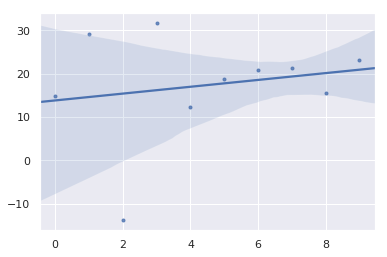

17.343693


In [11]:
num_episodes = 10

test_episode_scores = []


for i_episode in tqdm(range(num_episodes)):
    agent.reset()
    
    ep_score = 0
    for t in count():
        agent.env.render()
        next_state, reward, done, info = agent.take_action(remember=False, greedy=True)
            
        ep_score += reward
        
        if done:
            test_episode_scores.append(ep_score)
            break
        time.sleep(.01)
        
        
test_episode_scores = torch.cat(test_episode_scores).cpu().numpy()

sns.regplot(np.arange(len(test_episode_scores)), test_episode_scores, marker='.')
plt.show()
print(test_episode_scores.mean())

In [20]:
env.render()

array([], dtype=float64)

In [21]:
env.reset()

array([-0.08868987,  0.16742766,  0.08904331, -0.15639689, -0.98953754,
       -0.14427562,  0.        ,  1.03235614,  0.        ])